<a href="https://colab.research.google.com/github/Asura3301/makemore/blob/main/makemore_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Makemore** Part 5: Building "WaveNet"

We take the 2-layer MLP from previous makemore versions and make it deeper with a tree-like structure, arriving at a convolutional neural network architecture similar to the WaveNet (2016) from DeepMind.

[DeepMind blog post from 2016](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open("/content/drive/MyDrive/Colab Notebooks/Projects/makemore/names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0 # EOS/SOS
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset(train_test_split)
block_size = 8 # context length:how many characters we take to predict next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print("".join(itos[i] for i in context), "--->", itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xval, Yval = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [42]:
# train a deeper network

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # fan_in norm/kaiming init helps us to avoid too high saturation of model
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with running "momentum update")
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate forward pass
    if self.training:
      if x.ndim == 2: # (N, C), where N is the batch size, and C is the number of features or channels
        dim = 0
      if x.ndim == 3: # (N, L, C), where N is the batch size, L is the sequence length, and C is the number of features or channels
        dim = (0, 1)
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, -1, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [43]:
torch.manual_seed(42);

In [44]:
n_embd = 24       # the dimensionality of the character embedding vectors
n_hidden = 128    # the number of neurons in the hidden layer of MLP

# initial embedding matrix
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), # BatchNorm1d(vocab_size),
])

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].gamma *= 0.1 # because we used BatchNorm1d so we dont have to change weights, but instead we change gamma
  model.layers[-1].weight *= 0.1
  # all other layers apply gain
  # for layer in layers[:-1]:
  #   if isinstance(layer, Linear):
  #     layer.weight *= 5/3   # gain value

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

76579


In [49]:
# optimization step
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss func

  # backward pass
  for layer in model.layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update using SGD
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    # if p.grad is not None:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
    # break

      0/ 200000: 2.3561
  10000/ 200000: 1.9339
  20000/ 200000: 2.2957
  30000/ 200000: 2.5438
  40000/ 200000: 1.7496
  50000/ 200000: 1.8806
  60000/ 200000: 1.8991
  70000/ 200000: 2.1087
  80000/ 200000: 1.8425
  90000/ 200000: 2.1194
 100000/ 200000: 1.5598
 110000/ 200000: 1.6474
 120000/ 200000: 2.1110
 130000/ 200000: 1.5987
 140000/ 200000: 1.6465
 150000/ 200000: 2.1707
 160000/ 200000: 1.6418
 170000/ 200000: 1.7408
 180000/ 200000: 1.9388
 190000/ 200000: 1.4229


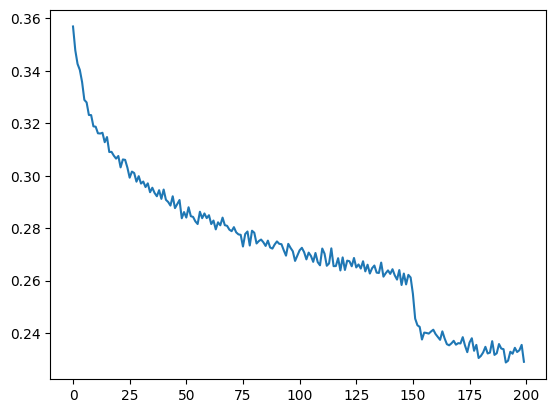

In [50]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# ix = torch.randint(0, Xtr.shape[0], (4,))
# Xb, Yb = Xtr[ix], Ytr[ix]
# logits = model(Xb)
# print(Xb.shape)
# Xb

In [54]:
for layer in model.layers:
  print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (1, 8, 24)
FlattenConsecutive : (1, 4, 48)
Linear : (1, 4, 128)
BatchNorm1d : (1, 4, 128)
Tanh : (1, 4, 128)
FlattenConsecutive : (1, 2, 256)
Linear : (1, 2, 128)
BatchNorm1d : (1, 2, 128)
Tanh : (1, 2, 128)
FlattenConsecutive : (1, 256)
Linear : (1, 128)
BatchNorm1d : (1, 128)
Tanh : (1, 128)
Linear : (1, 27)


In [51]:
# Put layers into evaluating mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [52]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7184996604919434
val 2.045196056365967


In [53]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample EOS/SOS token --> break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

muhammadmus.
rayshawn.
malayci.
malina.
marilyn.
eliyanna.
siddhanty.
loreli.
triston.
bow.
vitaghan.
kelere.
saelle.
zalma.
suncie.
mariferrat.
zayan.
damaon.
romonie.
estevea.


### performance log

- original (3 character context + 200 hidden neurons, 12K params):train 2.056,
val 2.1065
- context: 3 -> 8 (22K params): train 1.918, val 2.0335
- flat -> hierarchical: n_hidden = 200 -> 68  (22K params): train 1.941, val 2.029
- fix bug in batchnorm(22K params): train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.7184996604919434, val 2.045196056365967